In [1]:
%load_ext autoreload
%autoreload 2
%load_ext watermark
%watermark -v -n -m -p numpy,scipy,sklearn,pandas

Fri Mar 29 2019 

CPython 3.6.8
IPython 7.2.0

numpy 1.14.6
scipy 1.1.0
sklearn 0.20.1
pandas 0.24.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.20.5-arch1-1-ARCH
machine    : x86_64
processor  : 
CPU cores  : 16
interpreter: 64bit


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import nolds
import data
import mne

PROJ_ROOT = os.getenv('THESIS_ROOT')
DATA_ROOT = os.path.abspath(os.path.join(PROJ_ROOT, 'data'))
PROCESSED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'processed'))
RAW_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'raw'))
LABELED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'labeled'))
DURATIONS_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'durations'))
REC_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'recplots'))
DIRECT_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'direct'))
GAF_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'gaf'))
print(PROJ_ROOT)
print(DATA_ROOT)
print(PROCESSED_ROOT)
import sys
sys.path.append(os.path.join(PROJ_ROOT, 'src'))
CHANNEL_NAMES = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
META_COLUMN_NAMES = ['freq', 'RESP_4W', 'RESP_FIN', 'REMISE_FIN', 'AGE', 'SEX', 'M_1',
       'M_4', 'M_F', 'délka léčby', 'lék 1', 'lék 2', 'lék 3', 'lék 4']
META_FILE_NAME = 'DEP-POOL_Final_144.xlsx'
# meta_df = pd.read_excel(os.path.join(RAW_ROOT, META_FILE_NAME), index_col='ID', names=META_COLUMN_NAMES)

raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '50a.fif'))
t = pd.DataFrame(raw_fif.get_data())
data = pd.DataFrame(np.transpose(t.values), columns=CHANNEL_NAMES).values

/home/kovar/thesis_project/
/home/kovar/thesis_project/data
/home/kovar/thesis_project/data/processed
Opening raw data file /home/kovar/thesis_project/data/processed/50a.fif...
This filename (/home/kovar/thesis_project/data/processed/50a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 16930 =      0.000 ...    67.720 secs
Ready.


<ipython-input-2-1e7cd7d477f5>:32: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/50a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '50a.fif'))


# Models

In [74]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [75]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential
from keras import optimizers
from keras import initializers

from keras import backend as K
# K.set_floatx('float32')
# K.floatx()
from keras.wrappers.scikit_learn import KerasClassifier

# Prepare data

In [11]:
def f(row, col):
    if row[col] <= 26:
        return -1
    if row[col] <= 27:
        return 0
    else:
        return 1
def ff(row, col, n=5):
    for i in range(n):
        if row[col] <= metapkl.quantile((i+1)/n)[col]:
            return i
    
metapklpath = os.path.join(LABELED_ROOT, 'processed', 'meta', 'meta.pkl')
metapkl = pd.read_pickle(metapklpath)
metapkl['dep'] = metapkl.apply(lambda row: f(row, 'sc'), axis=1)
metapkl['dep_bef'] = metapkl.apply(lambda row: f(row, 'sc_bef'), axis=1)
metapkl['dep_aft'] = metapkl.apply(lambda row: f(row, 'sc_aft'), axis=1)
metapkl = metapkl.astype({'dep': 'category', 'dep_bef': 'category', 'dep_aft': 'category'})                                           
print(metapkl['dep'].value_counts())
print(metapkl['dep_bef'].value_counts())
print(metapkl['dep_aft'].value_counts())

def f(row, col):
    if row[col] <= metapkl.loc[(slice(None), 'a'), :].quantile(0.45)['change']:
        return -1
    if row[col] <= metapkl.loc[(slice(None), 'a'), :].quantile(0.56)['change']:
        return 0
    else:
        return 1
    
metapkl['resp'] = metapkl.apply(lambda row: f(row, 'change'), axis=1)
metapkl = metapkl.astype({'resp': 'category'})                                           
print(metapkl.loc[(slice(None), 'a'), 'resp'].value_counts())
pd.to_pickle(metapkl, metapklpath)

-1    181
 1     71
 0     14
Name: dep, dtype: int64
-1    126
 1    124
 0     16
Name: dep_bef, dtype: int64
-1    236
 1     18
 0     12
Name: dep_aft, dtype: int64
-1    60
 1    59
 0    14
Name: resp, dtype: int64


In [30]:
import numpy as np

def remove_middle(filenames, labels):
    ta = zip(filenames, labels)
    ta = np.array([(t, l) for t, l in ta], dtype=[('fname', 'S100'), ('label', 'int8')])
    ta = ta[:][(ta['label'] == -1) | (ta['label'] == 1)]
    ta['label'][ta['label'] == -1] = 0
    return ta['fname'].astype(str, copy=False), ta['label']

In [31]:
from sklearn.model_selection import GridSearchCV, train_test_split
from data.data_files import CHANNEL_NAMES, DataKind, files_builder
from keras.utils import to_categorical

fb = files_builder(DataKind('direct'), subfolder=())
seed = 123
# fns = [fn[1] for fn in fb.file_names(include_path=True, subfolder=(), recursive=True)]
filenames, labels = fb.get_filenames_with_labels(label='dep', trial=None)
filenames, labels = remove_middle(filenames, labels)
unique, counts = np.unique(labels, return_counts=True)
print('Overall samples: ', dict(zip(unique, counts)))
training_filenames, test_filenames, training_labels, test_labels = \
    train_test_split(filenames, labels, test_size=0.2, random_state=seed)
training_filenames, validation_filenames, training_labels, validation_labels = \
    train_test_split(training_filenames, training_labels, test_size=0.2, random_state=seed)
assert len(training_filenames) == len(training_labels)
assert len(validation_filenames) == len(validation_labels)
unique, counts = np.unique(training_labels, return_counts=True)
print('Training samples: ', dict(zip(unique, counts)))
unique, counts = np.unique(test_labels, return_counts=True)
print('Testing samples: ', dict(zip(unique, counts)))
unique, counts = np.unique(validation_labels, return_counts=True)
print('Validation samples: ', dict(zip(unique, counts)))
labels = to_categorical(labels, dtype=labels.dtype)
training_labels = to_categorical(training_labels, dtype=training_labels.dtype)
validation_labels = to_categorical(validation_labels, dtype=validation_labels.dtype)
test_labels = to_categorical(test_labels, dtype=test_labels.dtype)

Overall samples:  {0: 6858, 1: 5921}
Training samples:  {0: 4392, 1: 3786}
Testing samples:  {0: 1392, 1: 1164}
Validation samples:  {0: 1074, 1: 971}


# Train

In [80]:
from keras.utils import Sequence
from models import activity_paper, deep, low_tri_fc, model_1, nikitas, shallow, temp, vgg_like, train

ind = [False, False, False, False, False,
       False, False, False, False, False, 
       False, False, False, False, False, 
       True, False, False, False]

class batch_generator(Sequence):

    def __init__(self, filenames, labels, batch_size):
        self.filenames, self.labels = filenames, labels
        self.n = len(self.filenames)
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))
        # return len(self.filenames) // self.batch_size

    def __getitem__(self, idx):
        batch_x = self.filenames[idx * self.batch_size:min(self.n, (idx + 1) * self.batch_size)]
        batch_y = self.labels[idx * self.batch_size:min(self.n, (idx + 1) * self.batch_size)]
        # assert len(batch_x) == batch_size, batch_x
        # assert len(batch_y) == batch_size, batch_y

        return np.array([
            np.load(file_name)[:,:, None].astype('float32') \
            # np.expand_dims(np.load(file_name), axis=-1) \
            # np.expand_dims(np.mean(np.load(file_name)[:, :, ind], axis=-1), axis=-1) \
            for file_name in batch_x]), batch_y

def plot_history(history):
    import matplotlib.pyplot as plt
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
from keras import backend as K
K.image_data_format()

'channels_last'

In [81]:
image_height, image_width = 256, 256
# image_height, image_width = 256, 19
num_channels = 1
batch_size = 128
num_epochs= 50
dropout_rate = 0.5

In [82]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

training_batch_generator = batch_generator(training_filenames, training_labels, batch_size)
validation_batch_generator = batch_generator(validation_filenames, validation_labels, batch_size)

mchp_filepath = '/home/kovar/thesis_project/data/models/weights_temp_best.hdf5'
# model = define_temp(first_nonlin=k.activations.elu, later_nonlin=k.activations.elu)
model = shallow.shal_model(in_chans=19, input_time_length=256)
mcp = ModelCheckpoint(mchp_filepath, save_best_only=True, monitor='val_acc', save_weights_only=False)
history = model.fit_generator(generator=training_batch_generator,
                                      steps_per_epoch=len(training_batch_generator),
                                      epochs=num_epochs,
                                      verbose=1,
                                      validation_data=validation_batch_generator,
                                      validation_steps=len(validation_batch_generator),
                                      callbacks=[
                                            mcp,
                                      #     # EarlyStopping(patience=4),
                                      #     ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, 
                                      #                       min_lr=0.001)
                                      ],
                                      use_multiprocessing=True,
                                      workers=8,
                                      max_queue_size=32)
plot_history(history)

Epoch 1/50
38/38 [==============================] - 6s 170ms/step - loss: 0.8908 - acc: 0.5474 - val_loss: 0.6937 - val_acc: 0.5943
Epoch 2/50
38/38 [==============================] - 1s 18ms/step - loss: 0.9439 - acc: 0.5580 - val_loss: 0.7053 - val_acc: 0.6414
Epoch 3/50
38/38 [==============================] - 1s 34ms/step - loss: 0.9552 - acc: 0.5936 - val_loss: 0.8193 - val_acc: 0.6498
Epoch 4/50
38/38 [==============================] - 1s 35ms/step - loss: 0.8957 - acc: 0.6190 - val_loss: 0.8137 - val_acc: 0.6397
Epoch 5/50
38/38 [==============================] - 1s 37ms/step - loss: 0.9482 - acc: 0.6101 - val_loss: 0.6613 - val_acc: 0.6574
Epoch 6/50
38/38 [==============================] - 1s 35ms/step - loss: 0.8975 - acc: 0.6257 - val_loss: 0.6796 - val_acc: 0.6692
Epoch 7/50
38/38 [==============================] - 1s 36ms/step - loss: 0.9182 - acc: 0.6494 - val_loss: 0.6569 - val_acc: 0.6700
Epoch 8/50
38/38 [==============================] - 1s 36ms/step - loss: 0.8246 - 

Process ForkPoolWorker-21933:
Process ForkPoolWorker-21942:
Process ForkPoolWorker-21941:
Process ForkPoolWorker-21940:
Process ForkPoolWorker-21924:
Process ForkPoolWorker-21935:
Process ForkPoolWorker-21932:
Process ForkPoolWorker-21928:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-21925:
Process ForkPoolWorker-21938:
Process ForkPoolWorker-21930:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most

KeyboardInterrupt
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
Process ForkPoolWorker-21943:
Process ForkPoolWorker-21947:
Process ForkPoolWorker-21956:
Process ForkPoolWor

KeyboardInterrupt: 

  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kovar/miniconda3/envs/thesis/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/kovar/miniconda3/envs/th

In [16]:
from keras.models import load_model
mchp_filepath = '/home/kovar/thesis_project/data/models/weights_temp_best.hdf5'
model = load_model(mchp_filepath)
test_batch_generator = batch_generator(test_filenames, test_labels, batch_size)
model.evaluate_generator(test_batch_generator, steps=None, max_queue_size=10, workers=1, 
                         use_multiprocessing=False, verbose=0)

[0.7719487920853214, 0.6639838986233686]

/home/kovar/miniconda3/envs/thesis/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

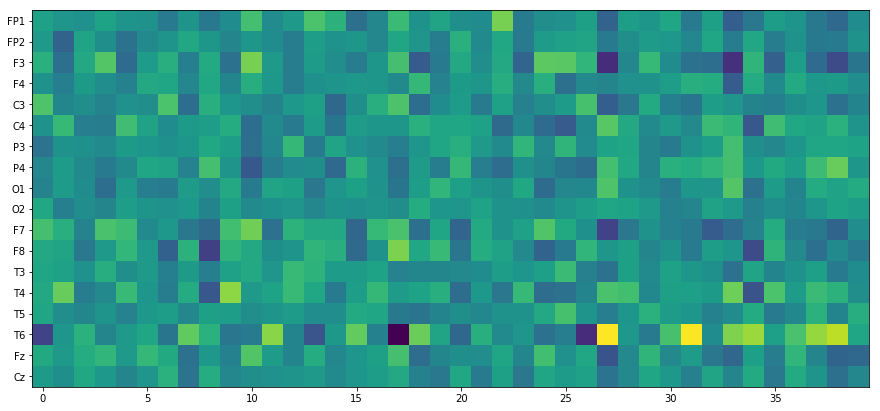

<Figure size 432x288 with 0 Axes>

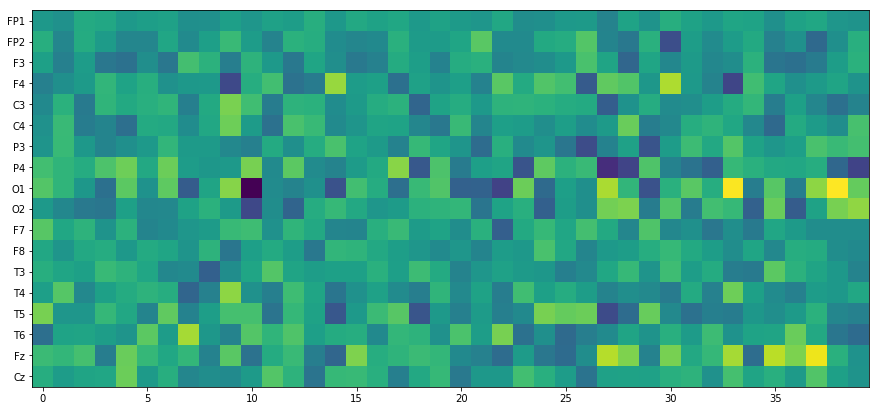

<Figure size 432x288 with 0 Axes>

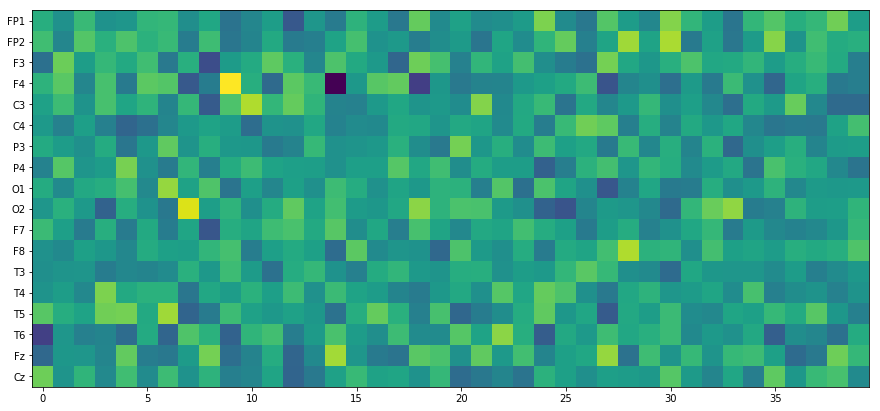

<Figure size 432x288 with 0 Axes>

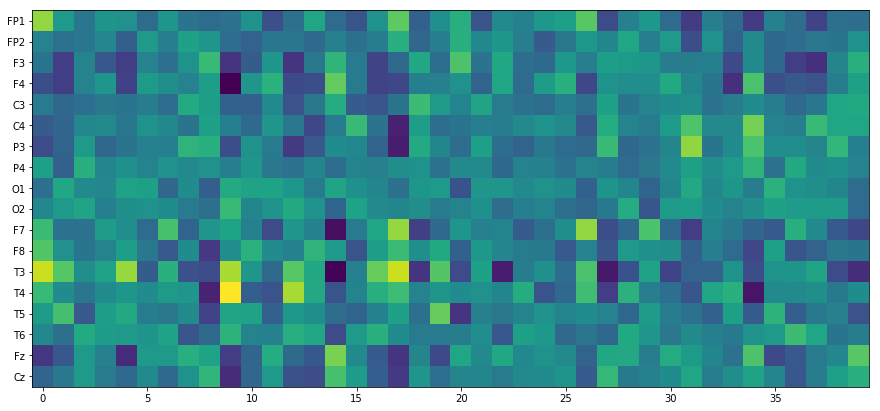

<Figure size 432x288 with 0 Axes>

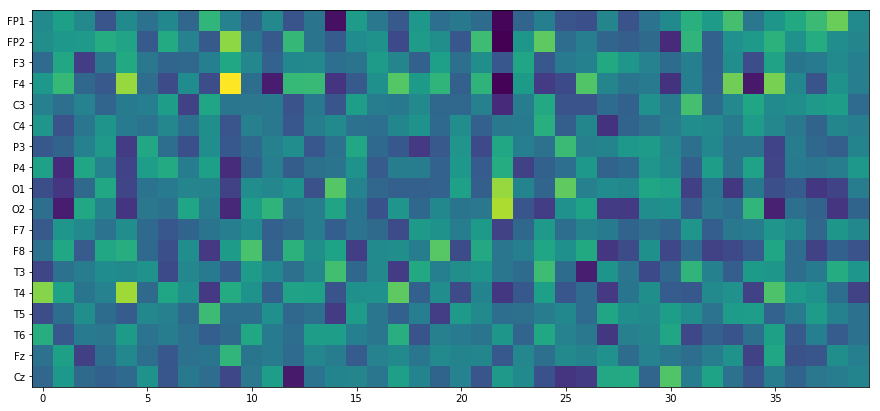

<Figure size 432x288 with 0 Axes>

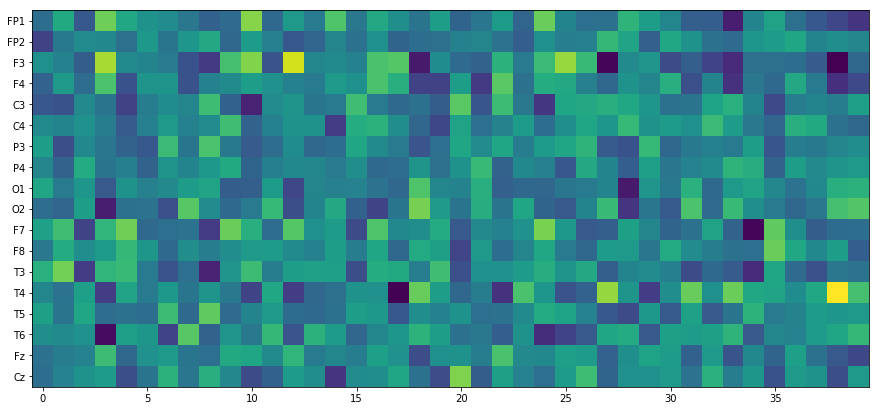

<Figure size 432x288 with 0 Axes>

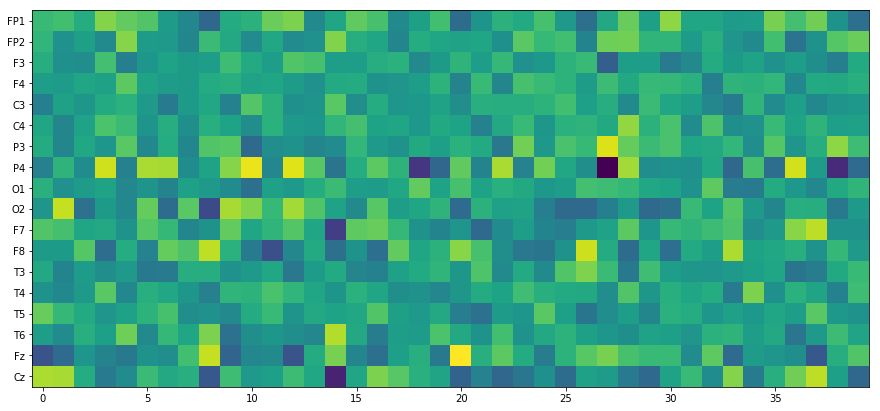

<Figure size 432x288 with 0 Axes>

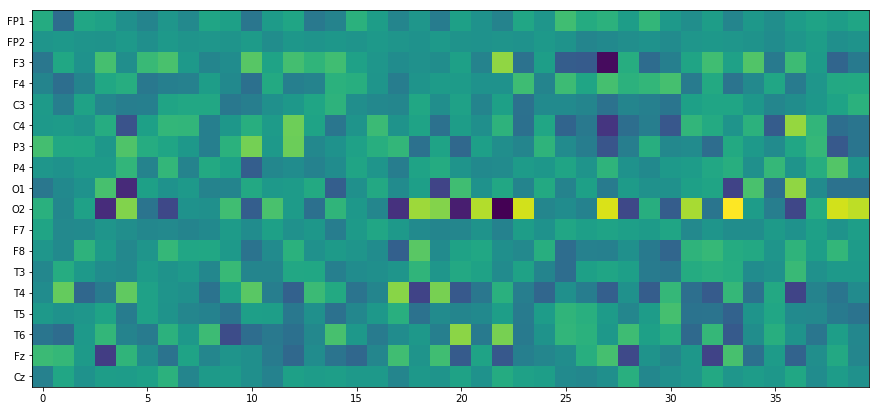

<Figure size 432x288 with 0 Axes>

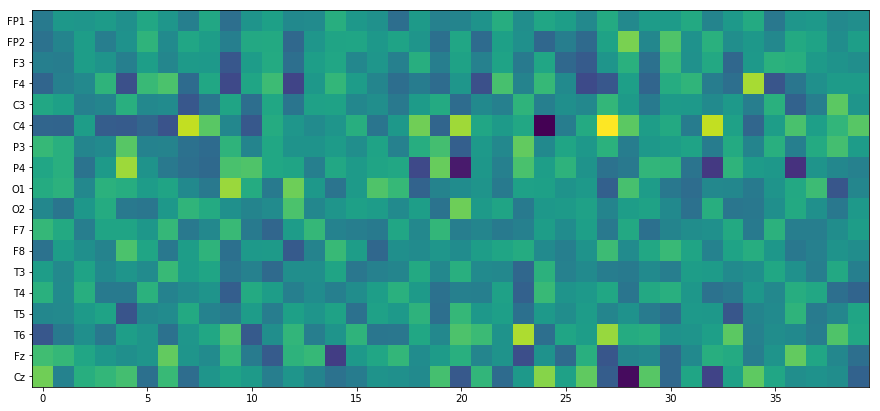

<Figure size 432x288 with 0 Axes>

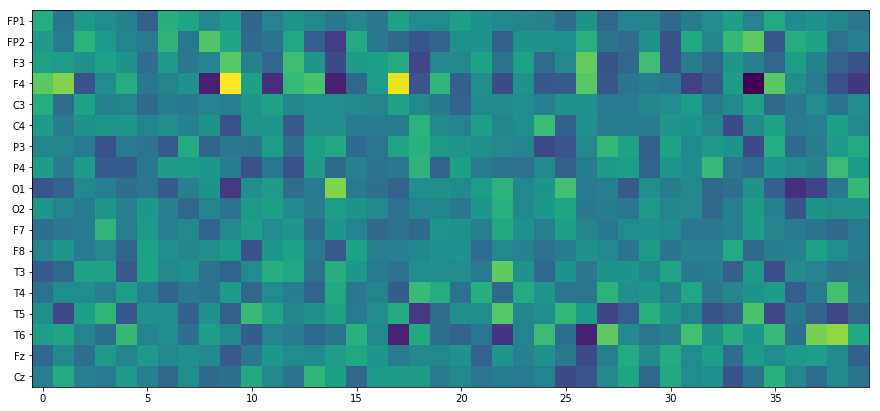

<Figure size 432x288 with 0 Axes>

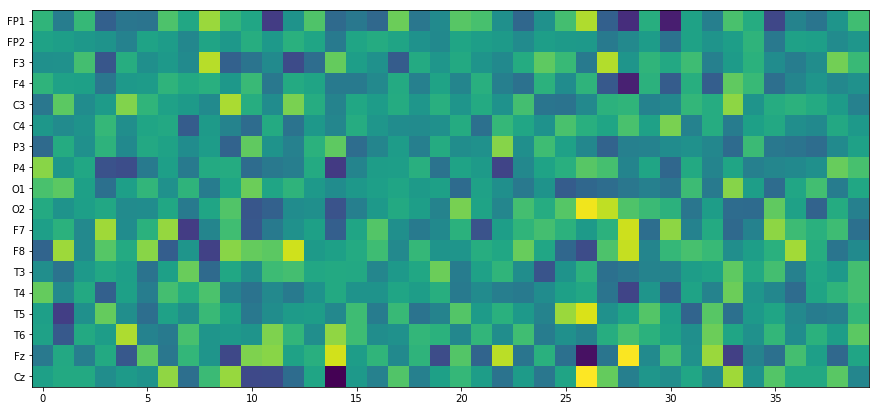

<Figure size 432x288 with 0 Axes>

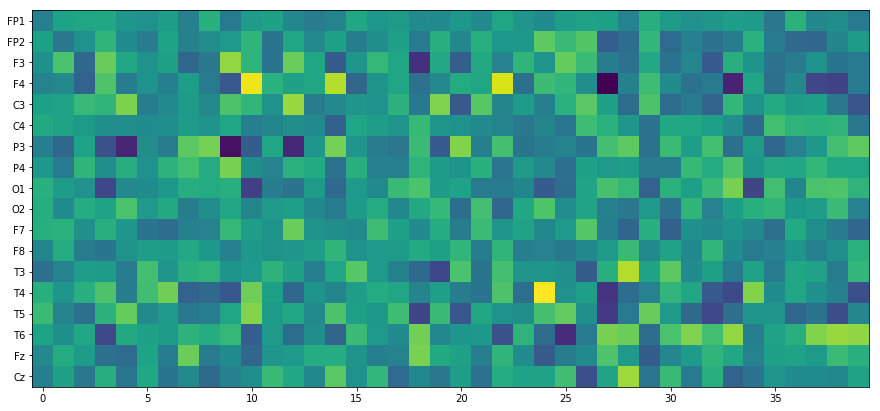

<Figure size 432x288 with 0 Axes>

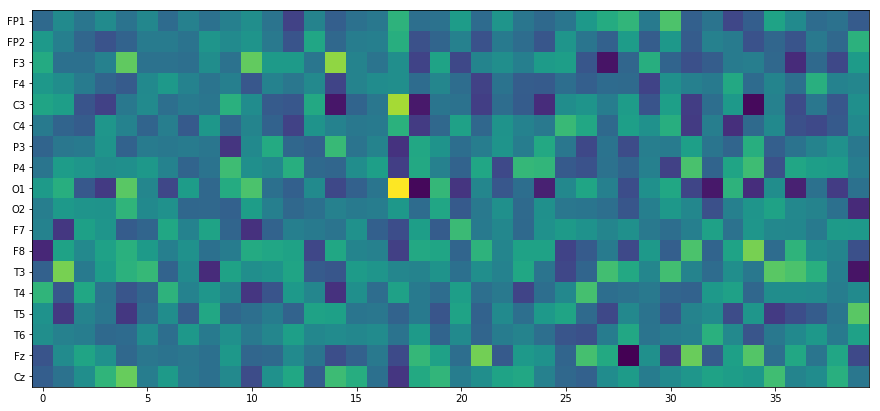

<Figure size 432x288 with 0 Axes>

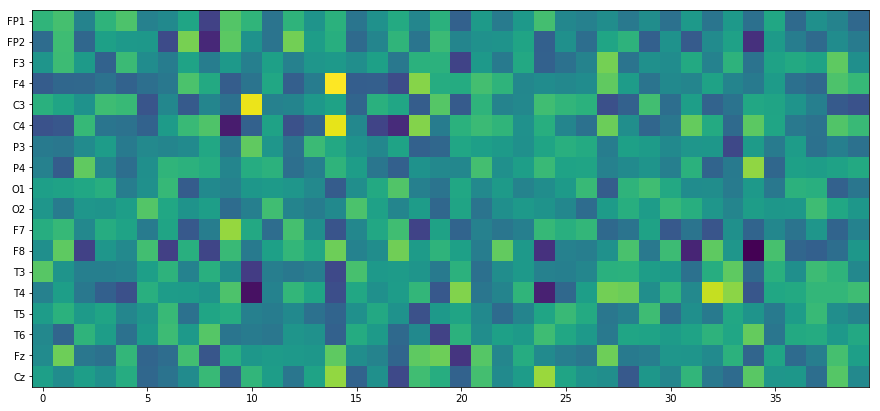

<Figure size 432x288 with 0 Axes>

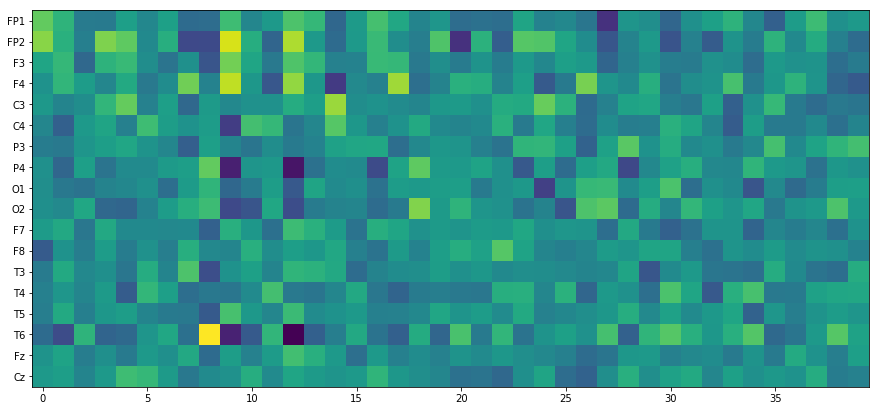

<Figure size 432x288 with 0 Axes>

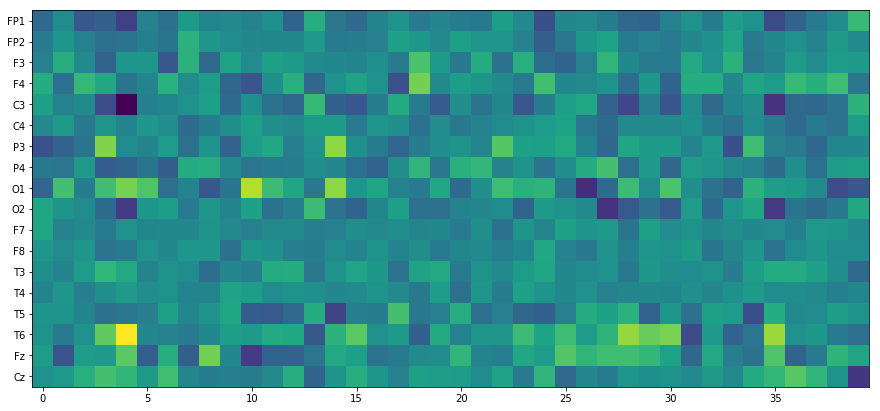

<Figure size 432x288 with 0 Axes>

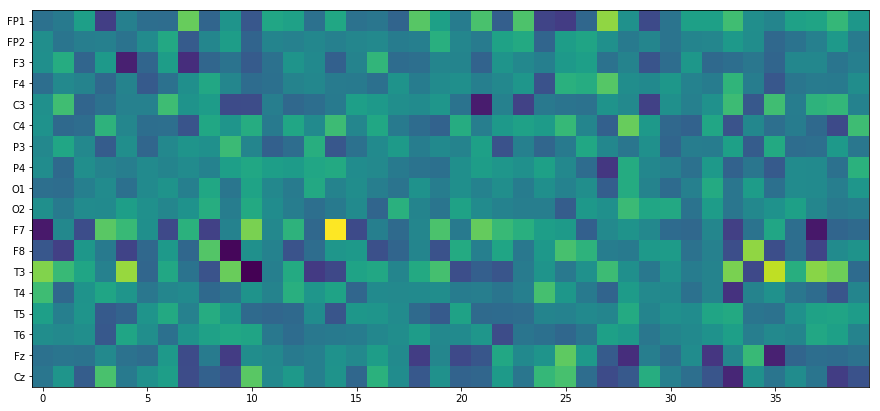

<Figure size 432x288 with 0 Axes>

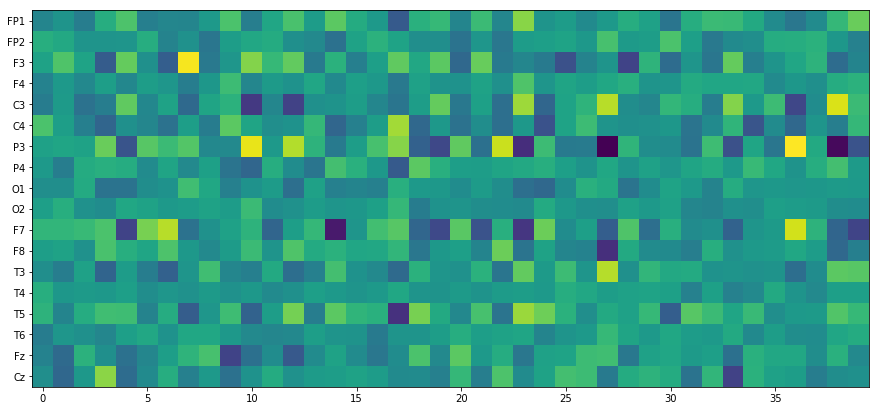

<Figure size 432x288 with 0 Axes>

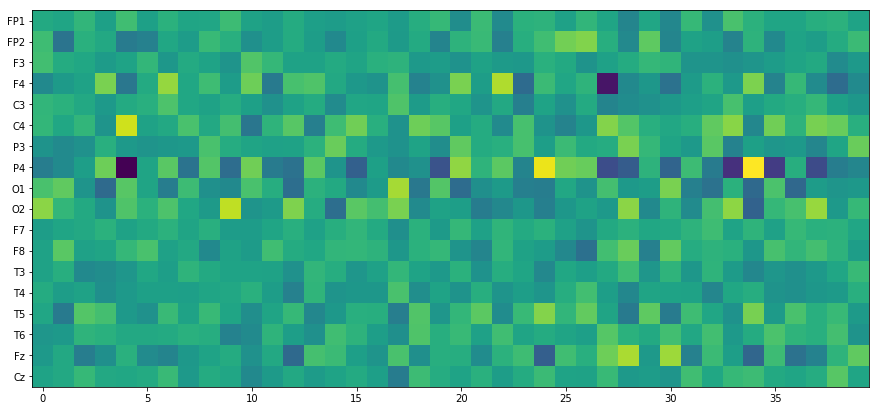

<Figure size 432x288 with 0 Axes>

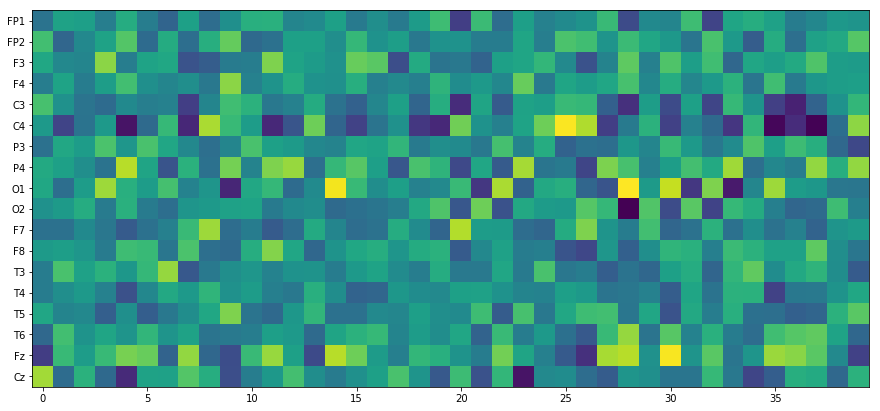

<Figure size 432x288 with 0 Axes>

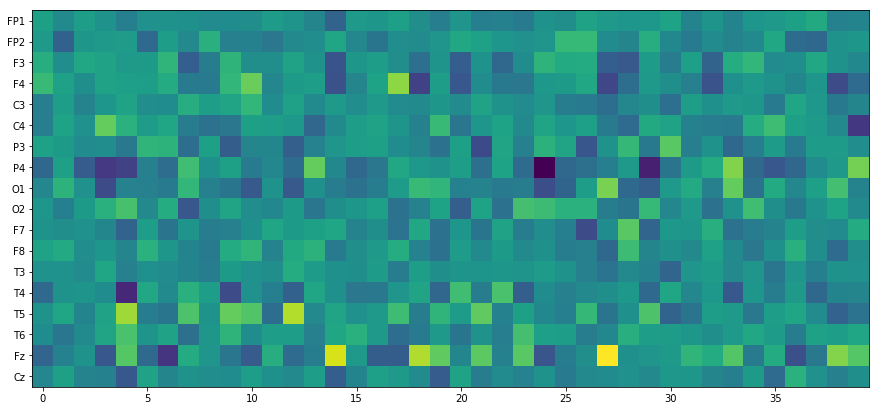

<Figure size 432x288 with 0 Axes>

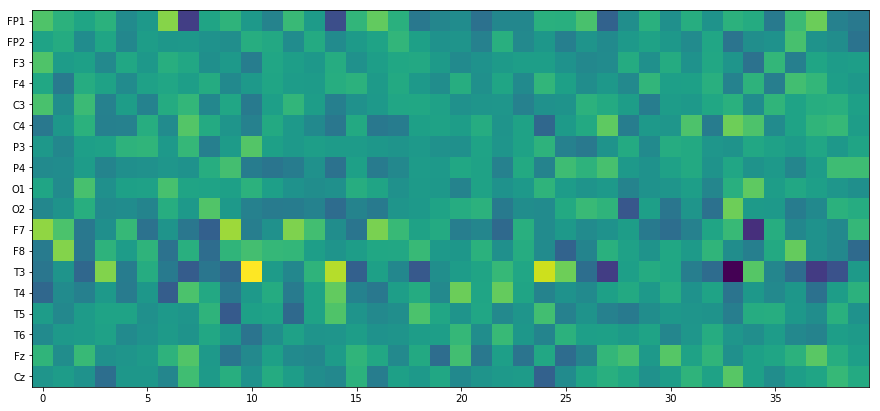

<Figure size 432x288 with 0 Axes>

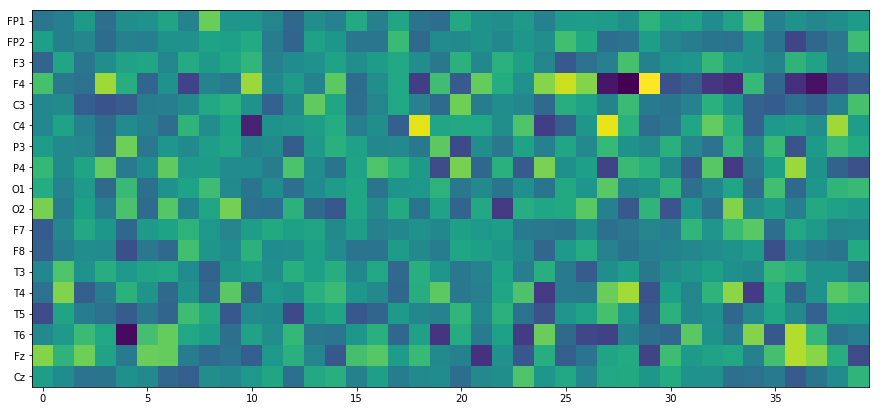

<Figure size 432x288 with 0 Axes>

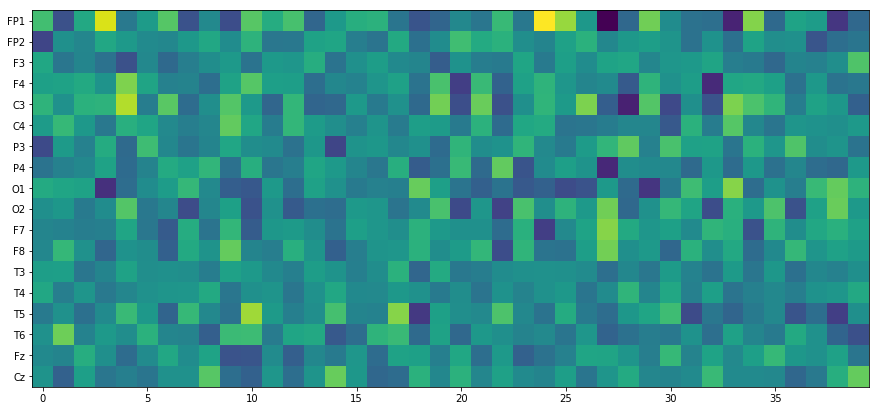

<Figure size 432x288 with 0 Axes>

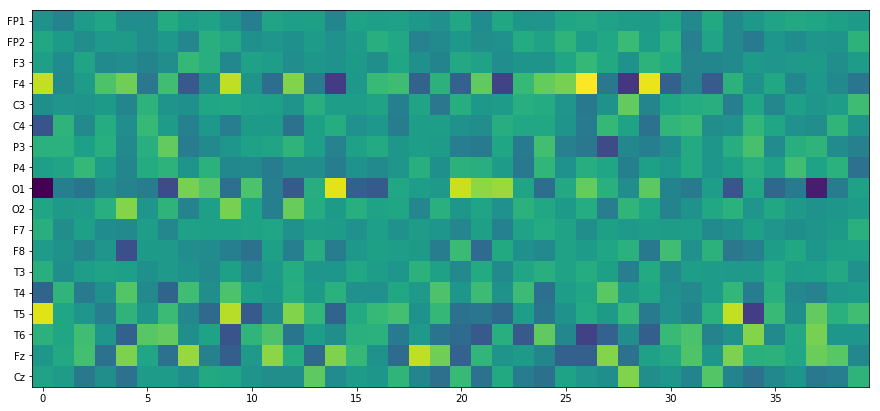

<Figure size 432x288 with 0 Axes>

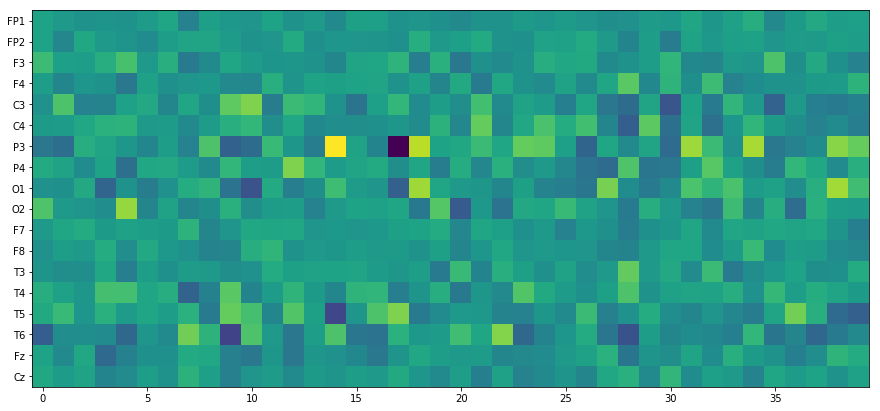

<Figure size 432x288 with 0 Axes>

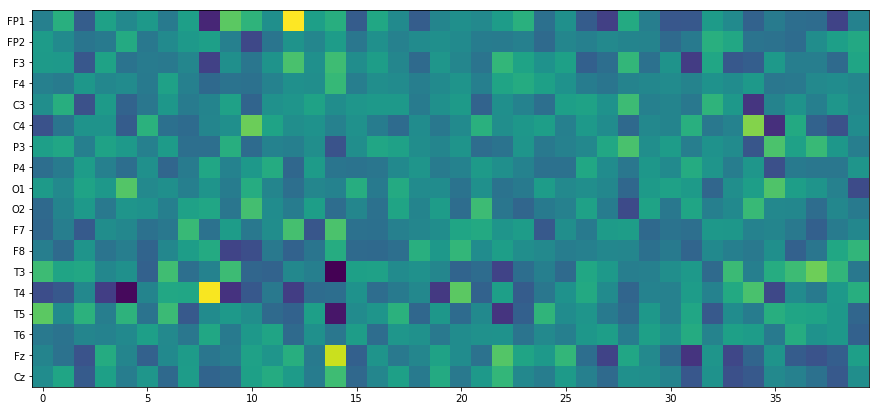

<Figure size 432x288 with 0 Axes>

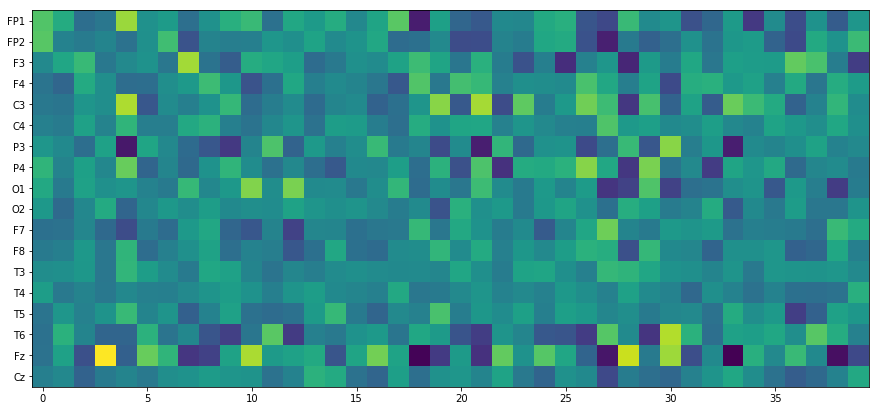

<Figure size 432x288 with 0 Axes>

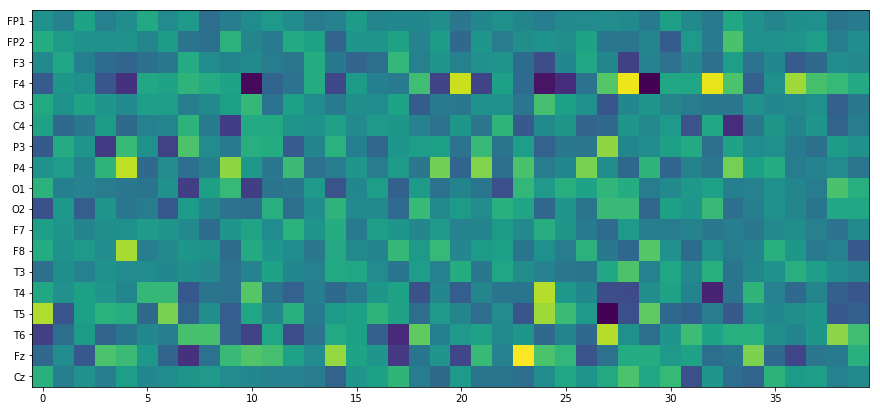

<Figure size 432x288 with 0 Axes>

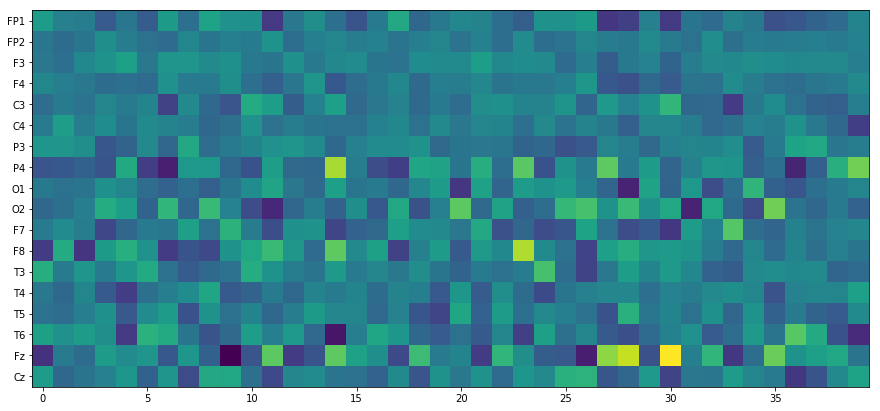

<Figure size 432x288 with 0 Axes>

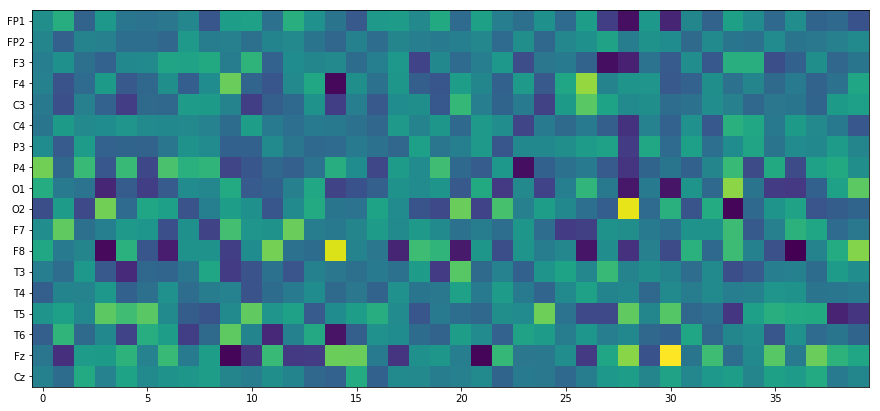

<Figure size 432x288 with 0 Axes>

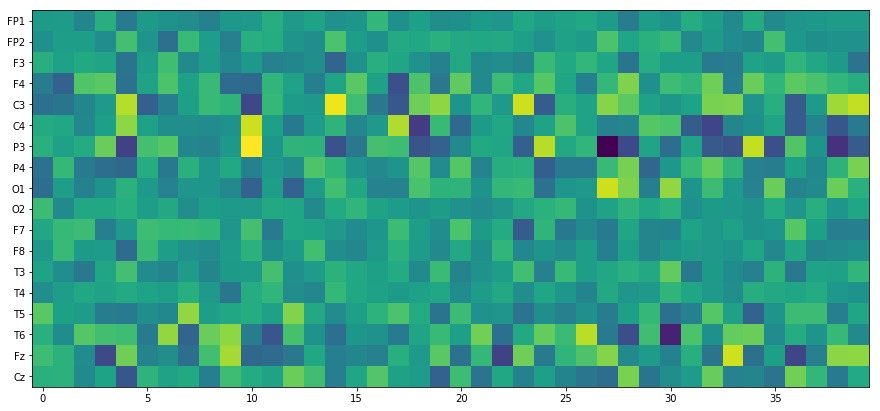

<Figure size 432x288 with 0 Axes>

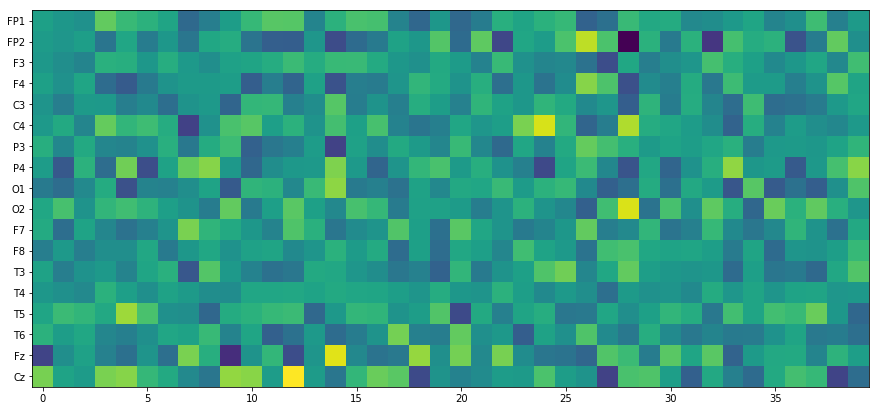

<Figure size 432x288 with 0 Axes>

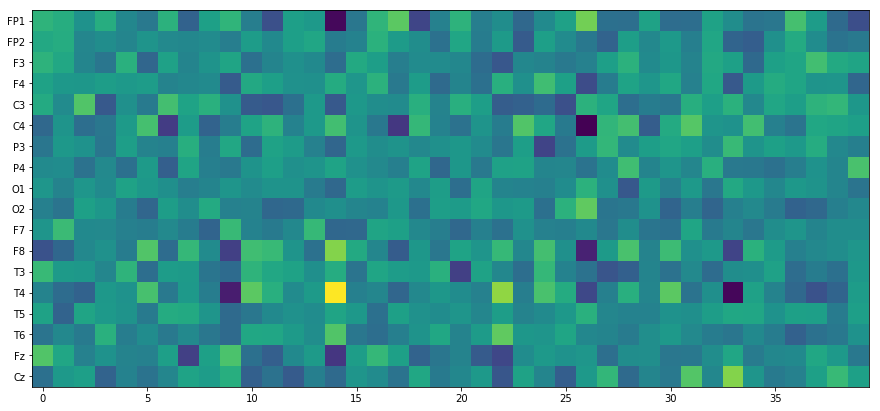

<Figure size 432x288 with 0 Axes>

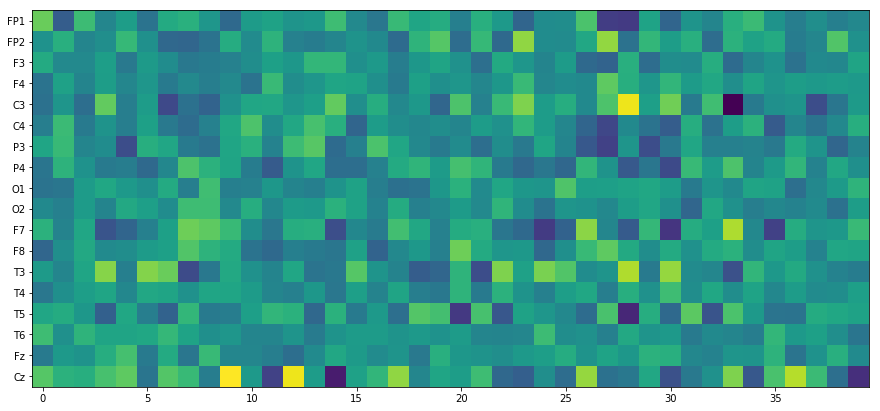

<Figure size 432x288 with 0 Axes>

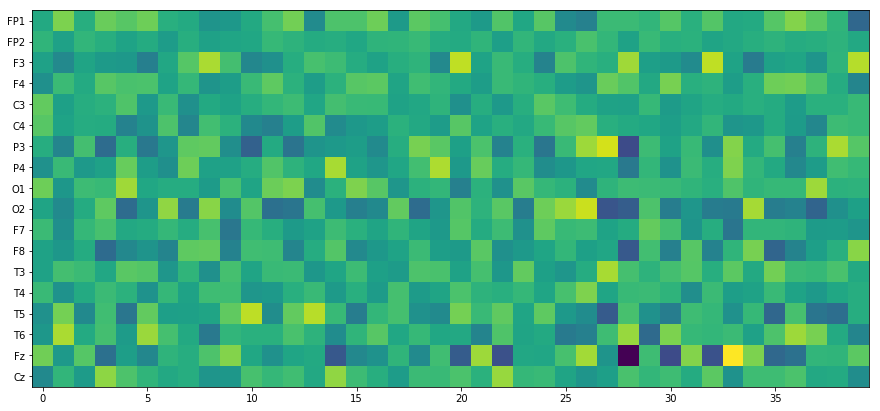

<Figure size 432x288 with 0 Axes>

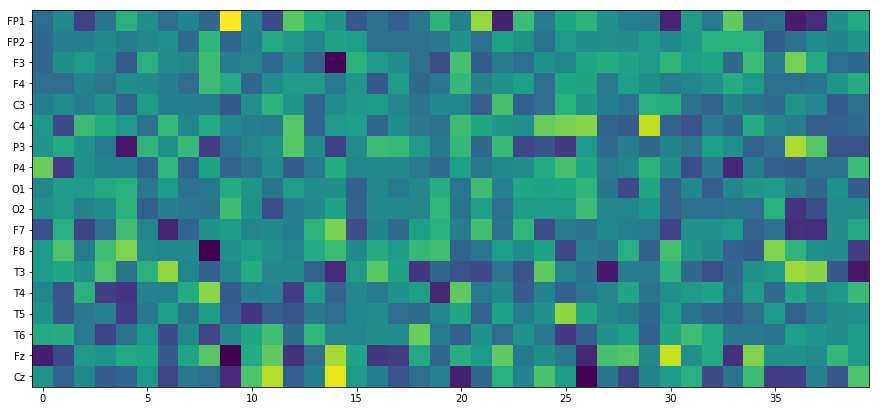

<Figure size 432x288 with 0 Axes>

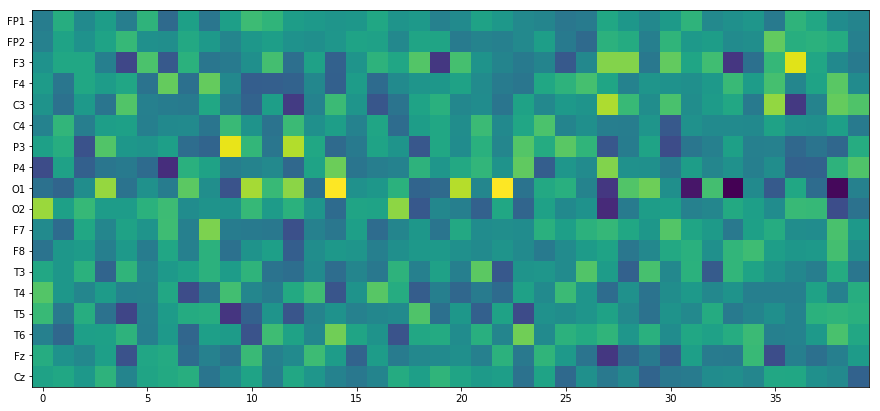

<Figure size 432x288 with 0 Axes>

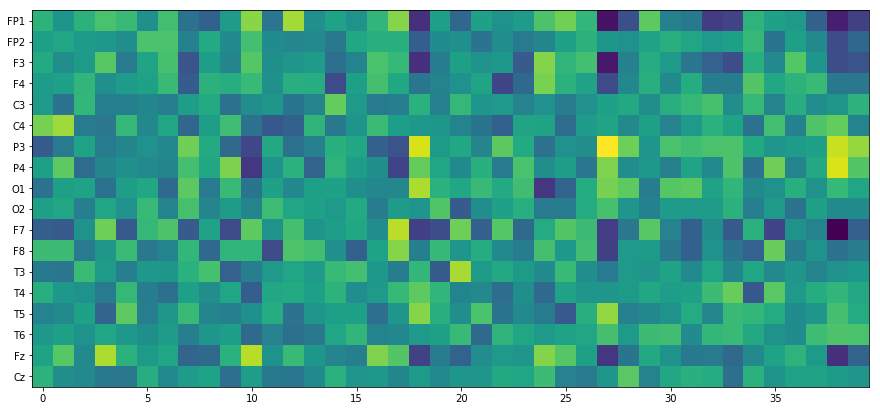

<Figure size 432x288 with 0 Axes>

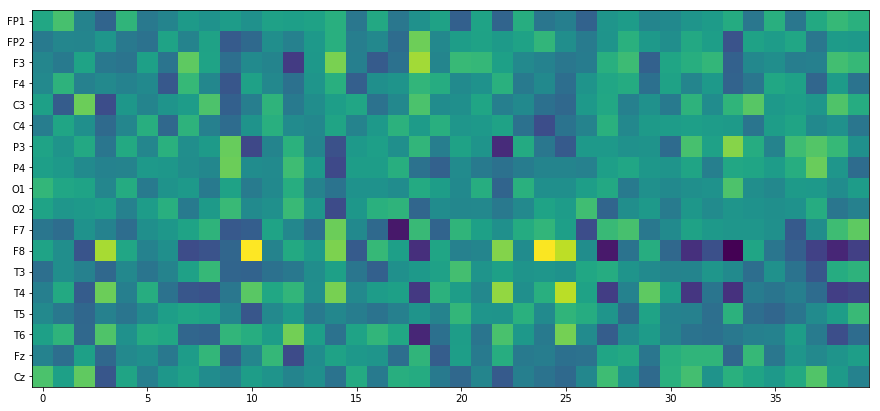

In [28]:
weights = model.get_weights()[1]
for channel in range(weights.shape[3]):
    plt.figure()
    fig, ax = plt.subplots(1,1,figsize=(15,15)) 
    ax.imshow(weights[:-1, 0, :, channel])
    ax.set_yticks(np.arange(0,18,1))
    ax.set_yticklabels(CHANNEL_NAMES)
    
    plt.plot()

## Evaluate with cross validation

In [10]:
from sklearn.model_selection import StratifiedKFold
import numpy
from sklearn.model_selection import GridSearchCV, train_test_split
from data.data_files import CHANNEL_NAMES, DataKind, files_builder
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

batch_size=128
seed = 123
numpy.random.seed(seed)

# fb = files_builder(DataKind('direct'), subfolder=())
fb = files_builder(DataKind('gaf'), subfolder=('cos_sim',))
# filenames, labels = fb.get_filenames_with_labels(label='resp', trial='a')
filenames, labels = fb.get_filenames_with_labels(label='dep')
filenames, labels = remove_middle(filenames, labels)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
mchp_filepath = '/home/kovar/thesis_project/data/models/weights_result_best.hdf5'
try:
    os.remove(mchp_filepath)
except:
    pass
cvscores = []
for i, (train, test) in enumerate(kfold.split(filenames, labels, random_state=seed)):
    cat_labels = to_categorical(labels)

    training_filenames, validation_filenames, training_labels, validation_labels = \
        train_test_split(filenames[train], cat_labels[train], test_size=0.2, random_state=seed)

    training_batch_generator = batch_generator(training_filenames, training_labels, batch_size)
    validation_batch_generator = batch_generator(validation_filenames, validation_labels, batch_size)
    test_batch_generator = batch_generator(filenames[test], cat_labels[test], batch_size)

    # model = define_bd_shal_model(in_chans=19, input_time_length=256)
    # model = define_bd_deep_model(in_chans=19, input_time_length=256)
    model = define_temp()
    mcp = ModelCheckpoint(mchp_filepath, save_best_only=True, monitor='val_acc', save_weights_only=False)
    print('FOLD ', i+1)
    history = model.fit_generator(generator=training_batch_generator,
                                          steps_per_epoch=len(training_batch_generator),
                                          epochs=num_epochs,
                                          verbose=0,
                                          validation_data=validation_batch_generator,
                                          validation_steps=len(validation_batch_generator),
                                          callbacks=[
                                              mcp,
                                          #     # EarlyStopping(patience=4),
                                          #     ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, 
                                          #                       min_lr=0.001)
                                          ],
                                          use_multiprocessing=True,
                                          workers=8,
                                          max_queue_size=32)

    model = load_model(mchp_filepath)
    scores = model.evaluate_generator(test_batch_generator, steps=None, max_queue_size=10, workers=1, 
                             use_multiprocessing=False, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

NameError: name 'define_temp' is not defined

## Fixed CV

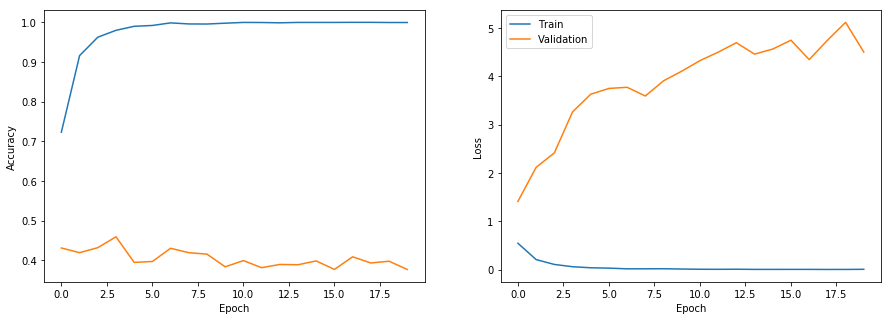

In [43]:
from keras.utils import Sequence
from models import activity_paper, deep, low_tri_fc, model_1, nikitas, shallow, temp, vgg_like, train
from sklearn.preprocessing import MinMaxScaler

class batch_generator(Sequence):

    def __init__(self, filenames, labels, batch_size):
        self.filenames, self.labels = filenames, labels
        self.n = len(self.filenames)
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.filenames[idx * self.batch_size:min(self.n, (idx + 1) * self.batch_size)]
        batch_y = self.labels[idx * self.batch_size:min(self.n, (idx + 1) * self.batch_size)]

        return np.array([
            np.load(file_name)[:,:, None].astype('float32') \
            for file_name in batch_x]), batch_y

def plot_history(history):
    import matplotlib.pyplot as plt
    # summarize history for accuracy
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    ax[0].plot(history.history['acc'])
    ax[0].plot(history.history['val_acc'])
    # ax[0].set_title('model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    # ax[0].legend(['Train', 'Validation'], loc='upper left')
    # summarize history for loss
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    # ax[1].set_title('model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    
from keras import backend as K
K.image_data_format()
plot_history(history)

In [30]:
def get_indeces_and_labels(indeces, labels, trial=None):
    ta = np.array([(ind[0], ind[1], lab) for ind, lab in zip(indeces, labels)],
                  dtype=[('index', 'int8'), ('trial', 'S8'), ('label', 'int8')])
    ta = ta[:][(ta['label'] == -1) | (ta['label'] == 1)]
    ta['label'][ta['label'] == -1] = 0
    if trial is not None:
        ta = (ta[:][ta['trial'] == np.bytes_(trial)])
    return ta[['index', 'trial']], ta['label']

def filenames_and_labels_from_indeces(indeces, fb, label):
    index_trials = [''.join((str(ind), tri.decode('utf-8'))) for ind, tri in 
                    zip(indeces['index'], indeces['trial'])]
    file_names = [fn for _, fn in fb.file_names(include_path=True, index_trials=index_trials)]
    file_names, labels = fb.get_filenames_with_labels(file_names=file_names, label=label)
    labels = [0 if l==-1 else l for l in labels]
    return file_names, labels

def show_class_dists(training_labels, test_labels, validation_labels):
    unique, counts = np.unique(training_labels, return_counts=True)
    print('Training samples: ', dict(zip(unique, counts)))
    unique, counts = np.unique(test_labels, return_counts=True)
    print('Testing samples: ', dict(zip(unique, counts)))
    unique, counts = np.unique(validation_labels, return_counts=True)
    print('Validation samples: ', dict(zip(unique, counts)))

All samples:  {0: 63, 1: 62}
Training samples:  {0: 2607, 1: 2445}
Testing samples:  {0: 873, 1: 834}
Validation samples:  {0: 694, 1: 699}
FOLD  1
Epoch 1/20
40/40 [==============================] - 7s 186ms/step - loss: 0.5315 - acc: 0.7374 - val_loss: 1.1692 - val_acc: 0.4724
Epoch 2/20
40/40 [==============================] - 5s 118ms/step - loss: 0.1959 - acc: 0.9220 - val_loss: 1.6159 - val_acc: 0.4781
Epoch 3/20
40/40 [==============================] - 4s 93ms/step - loss: 0.0963 - acc: 0.9678 - val_loss: 1.8511 - val_acc: 0.4939
Epoch 4/20
40/40 [==============================] - 4s 92ms/step - loss: 0.0595 - acc: 0.9820 - val_loss: 2.1392 - val_acc: 0.4810
Epoch 5/20
40/40 [==============================] - 4s 99ms/step - loss: 0.0291 - acc: 0.9943 - val_loss: 2.0817 - val_acc: 0.5047
Epoch 6/20
40/40 [==============================] - 4s 95ms/step - loss: 0.0258 - acc: 0.9931 - val_loss: 2.7979 - val_acc: 0.4358
Epoch 7/20
40/40 [==============================] - 4s 102ms/ste

/home/kovar/miniconda3/envs/thesis/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126496). Check your callbacks.
  % delta_t_median)


40/40 [==============================] - 4s 106ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 3.1171 - val_acc: 0.4824
Epoch 19/20
40/40 [==============================] - 4s 97ms/step - loss: 0.0059 - acc: 0.9986 - val_loss: 3.3121 - val_acc: 0.4953
Epoch 20/20
40/40 [==============================] - 4s 101ms/step - loss: 0.0380 - acc: 0.9867 - val_loss: 3.4143 - val_acc: 0.4795


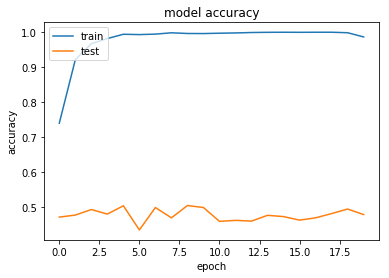

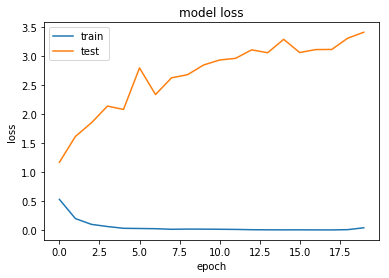

acc: 56.18%
Training samples:  {0: 2807, 1: 2374}
Testing samples:  {0: 908, 1: 757}
Validation samples:  {0: 459, 1: 847}
FOLD  2
Epoch 1/20
41/41 [==============================] - 8s 203ms/step - loss: 0.5222 - acc: 0.7323 - val_loss: 1.0494 - val_acc: 0.5168
Epoch 2/20
41/41 [==============================] - 3s 84ms/step - loss: 0.2086 - acc: 0.9167 - val_loss: 1.3923 - val_acc: 0.5008
Epoch 3/20
41/41 [==============================] - 4s 97ms/step - loss: 0.1045 - acc: 0.9640 - val_loss: 1.3806 - val_acc: 0.4877
Epoch 4/20
41/41 [==============================] - 4s 100ms/step - loss: 0.0585 - acc: 0.9838 - val_loss: 1.8332 - val_acc: 0.4908
Epoch 5/20
41/41 [==============================] - 4s 102ms/step - loss: 0.0415 - acc: 0.9888 - val_loss: 1.9607 - val_acc: 0.4977
Epoch 6/20
41/41 [==============================] - 4s 101ms/step - loss: 0.0307 - acc: 0.9912 - val_loss: 1.8445 - val_acc: 0.5314
Epoch 7/20
41/41 [==============================] - 4s 96ms/step - loss: 0.0239

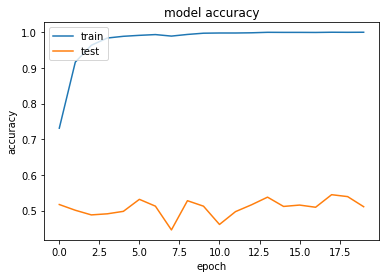

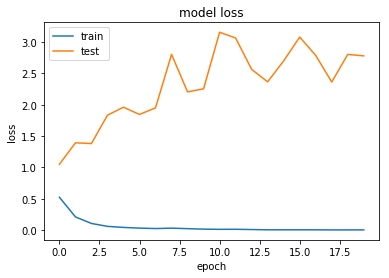

acc: 58.68%
Training samples:  {0: 2538, 1: 2610}
Testing samples:  {0: 879, 1: 824}
Validation samples:  {0: 757, 1: 544}
FOLD  3
Epoch 1/20
41/41 [==============================] - 9s 215ms/step - loss: 0.5636 - acc: 0.7044 - val_loss: 0.8360 - val_acc: 0.6103
Epoch 2/20
41/41 [==============================] - 3s 84ms/step - loss: 0.2226 - acc: 0.9120 - val_loss: 1.2087 - val_acc: 0.6318
Epoch 3/20
41/41 [==============================] - 4s 98ms/step - loss: 0.1047 - acc: 0.9640 - val_loss: 1.4187 - val_acc: 0.5811
Epoch 4/20
41/41 [==============================] - 4s 98ms/step - loss: 0.0596 - acc: 0.9827 - val_loss: 1.6988 - val_acc: 0.5811
Epoch 5/20
41/41 [==============================] - 4s 98ms/step - loss: 0.0412 - acc: 0.9884 - val_loss: 1.6955 - val_acc: 0.5926
Epoch 6/20
41/41 [==============================] - 4s 101ms/step - loss: 0.0314 - acc: 0.9924 - val_loss: 2.0409 - val_acc: 0.6295
Epoch 7/20
41/41 [==============================] - 4s 104ms/step - loss: 0.0284 

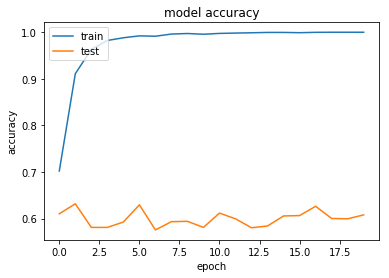

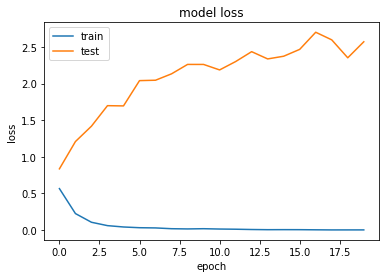

acc: 57.31%
Training samples:  {0: 2796, 1: 2478}
Testing samples:  {0: 764, 1: 742}
Validation samples:  {0: 614, 1: 758}
FOLD  4
Epoch 1/20
42/42 [==============================] - 10s 231ms/step - loss: 0.5712 - acc: 0.7070 - val_loss: 1.2892 - val_acc: 0.4577
Epoch 2/20
42/42 [==============================] - 4s 86ms/step - loss: 0.2440 - acc: 0.8996 - val_loss: 2.0038 - val_acc: 0.4730
Epoch 3/20
42/42 [==============================] - 4s 102ms/step - loss: 0.1258 - acc: 0.9544 - val_loss: 1.9910 - val_acc: 0.5109
Epoch 4/20
42/42 [==============================] - 4s 94ms/step - loss: 0.0790 - acc: 0.9719 - val_loss: 2.4382 - val_acc: 0.4949
Epoch 5/20
42/42 [==============================] - 4s 99ms/step - loss: 0.0382 - acc: 0.9914 - val_loss: 2.7939 - val_acc: 0.4862
Epoch 6/20
42/42 [==============================] - 4s 105ms/step - loss: 0.0349 - acc: 0.9902 - val_loss: 2.8859 - val_acc: 0.4985
Epoch 7/20
42/42 [==============================] - 5s 108ms/step - loss: 0.028

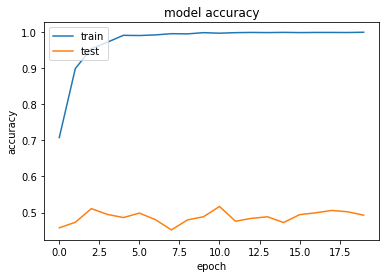

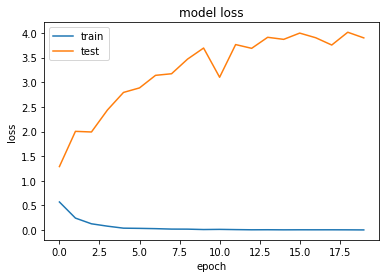

acc: 56.04%
Training samples:  {0: 2909, 1: 2323}
Testing samples:  {0: 750, 1: 821}
Validation samples:  {0: 515, 1: 834}
FOLD  5
Epoch 1/20
41/41 [==============================] - 10s 242ms/step - loss: 0.5431 - acc: 0.7236 - val_loss: 1.4106 - val_acc: 0.4314
Epoch 2/20
41/41 [==============================] - 4s 87ms/step - loss: 0.2061 - acc: 0.9161 - val_loss: 2.1140 - val_acc: 0.4196
Epoch 3/20
41/41 [==============================] - 4s 104ms/step - loss: 0.1052 - acc: 0.9625 - val_loss: 2.4138 - val_acc: 0.4322
Epoch 4/20
41/41 [==============================] - 4s 99ms/step - loss: 0.0582 - acc: 0.9799 - val_loss: 3.2615 - val_acc: 0.4596
Epoch 5/20
41/41 [==============================] - 4s 98ms/step - loss: 0.0363 - acc: 0.9901 - val_loss: 3.6283 - val_acc: 0.3951
Epoch 6/20
41/41 [==============================] - 4s 107ms/step - loss: 0.0290 - acc: 0.9922 - val_loss: 3.7480 - val_acc: 0.3973
Epoch 7/20
41/41 [==============================] - 4s 108ms/step - loss: 0.014

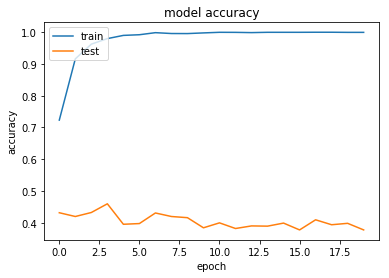

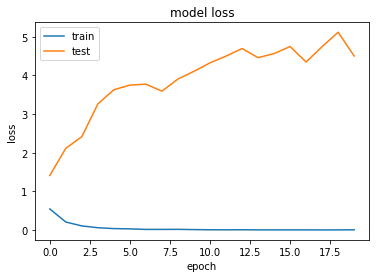

acc: 57.48%
57.14% (+/- 0.96%)


In [31]:
from sklearn.model_selection import StratifiedKFold
import keras as k
import numpy
from sklearn.model_selection import GridSearchCV, train_test_split
from data.data_files import CHANNEL_NAMES, DataKind, files_builder
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from models import activity_paper, deep, low_tri_fc, model_1, nikitas, shallow, temp, vgg_like, train
from importlib import reload

class_label = 'dep'
trial = 'a'
batch_size= 128
num_epochs = 20
test_size = 0.2
seed = 123
show_dists = True
join_train_val = False
fb = files_builder(DataKind('direct'), subfolder=())
mchp_filepath = '/home/kovar/thesis_project/data/models/weights_result_best.hdf5'
metapklpath = os.path.join(LABELED_ROOT, 'processed', 'meta', 'meta.pkl')

numpy.random.seed(seed)
metapkl = pd.read_pickle(metapklpath)

indeces, labels = get_indeces_and_labels(metapkl.index.values, list(metapkl[class_label].values), trial=trial)
unique, counts = np.unique(labels, return_counts=True)
print('All samples: ', dict(zip(unique, counts)))

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
try:
    os.remove(mchp_filepath)
except:
    pass
cvscores = []
for i, (train, test) in enumerate(kfold.split(indeces, labels)):

    if join_train_val:
        tv_filenames, tv_labels = filenames_and_labels_from_indeces(indeces[train], fb, class_label)    
        training_filenames, validation_filenames, training_labels, validation_labels = \
            train_test_split(tv_filenames, tv_labels, test_size=test_size, random_state=seed)
    else:
        training_indeces, validation_indeces = \
            train_test_split(indeces[train], test_size=test_size, random_state=seed)
        training_filenames, training_labels = filenames_and_labels_from_indeces(training_indeces, fb, class_label)
        validation_filenames, validation_labels = filenames_and_labels_from_indeces(validation_indeces, fb, class_label)
    
    test_filenames, test_labels = filenames_and_labels_from_indeces(indeces[test], fb, class_label)
    if show_dists:
        show_class_dists(training_labels, test_labels, validation_labels)
    training_labels = to_categorical(training_labels, num_classes=2, dtype=int)
    validation_labels = to_categorical(validation_labels, num_classes=2, dtype=int)
    test_labels = to_categorical(test_labels, num_classes=2, dtype=int)

    training_batch_generator = batch_generator(training_filenames, training_labels, batch_size)
    validation_batch_generator = batch_generator(validation_filenames, validation_labels, batch_size)
    test_batch_generator = batch_generator(test_filenames, test_labels, batch_size)
    
    mcp = ModelCheckpoint(mchp_filepath, save_best_only=True, monitor='val_acc', save_weights_only=False)
    model = shallow.shal_model(in_chans=19, input_time_length=1024, drop_prob=0.5)
    # model = temp.temp_model()
    model.compile(
        # optimizer=k.optimizers.SGD(lr=0.01, momentum=0.99, decay=1e-5, nesterov=True),
        # optimizer=k.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
        optimizer=k.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
        loss=k.losses.binary_crossentropy,
        metrics=['accuracy'],
        # loss_weights=None,
        # sample_weight_mode=None,
        # weighted_metrics=None, 
        # target_tensors=None
    )
    print('FOLD ', i+1)
    history = model.fit_generator(generator=training_batch_generator,
                                          steps_per_epoch=len(training_batch_generator),
                                          epochs=num_epochs,
                                          verbose=1,
                                          validation_data=validation_batch_generator,
                                          validation_steps=len(validation_batch_generator),
                                          callbacks=[
                                              mcp,
                                          #     # EarlyStopping(patience=4),
                                          #      k.callbacks.ReduceLROnPlateau(
                                          #          monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
                                          ],
                                          use_multiprocessing=True,
                                          workers=8,
                                          max_queue_size=32)
    plot_history(history)
    model = load_model(mchp_filepath)
    # Here I may loop per persons in test set and report average accuracy per person instead of overall accuracy
    scores = model.evaluate_generator(test_batch_generator, steps=None, max_queue_size=10, workers=1, 
                             use_multiprocessing=False, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

## Other

In [35]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    number_size = 4.0
    if K.floatx() == 'float16':
         number_size = 2.0
    if K.floatx() == 'float64':
         number_size = 8.0

    print('Total paramaters: {:,}'.format(trainable_count + non_trainable_count))
    total_memory = number_size*(batch_size*shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes
get_model_memory_usage(128, define_model_1())

Total paramaters: 12,694.0


2.518